In [1]:
#Functionality of the ddpg model by default 'Pixel Maximizer' and 'Black Pixel Maximizer' are created
Model_Name = "Pixel Maximizer"

In [2]:
#Start training from previous checkpoint or not (only default Model_Type can have True)
continue_training = False

In [3]:
#cell to be used only if running in Google colab, for mounting Drive for I/O
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Even Google colab doesn't have these libraries by default so install them
!pip install svgwrite
!pip install svglib

In [5]:
#Setup working directory
import os
working_directory = '/content/drive/MyDrive/vinci-old'
os.chdir(working_directory)
os.getcwd()

'/content/drive/MyDrive/vinci-old'

In [6]:
#Created libraries import
import sketch_rnn as srnn
from HyperParameters import HP
import draw

In [7]:
#Installed libraries import
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import cv2

In [8]:
#Load the reference image and get the bounds of the image which will set the max stroke length
x = np.load(HP.data_location)
min_x, max_x, min_y, max_y = draw.get_bounds(x, 0.2)

In [9]:
#Training model helper functions
@tf.function
def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
    """
    This function samples from a 2D-gaussian distribution
    
    Args:
    mu1: mean of the distribution along x-direction
    mu2: mean of the distribution along y-direction
    s1: std. deviation along x-direction
    s2: std. deviation along y-direction
    rho: correlation between the two distributiions
    
    Returns:
    a single sample from the distribution
    """
    mean = tf.concat((mu1, mu2), axis=1)
    r1 = tf.expand_dims(tf.concat((s1*s1, rho*s1*s2), axis=-1), axis=2)
    r2 = tf.expand_dims(tf.concat((rho*s1*s2, s2*s2), axis=-1), axis=2)
    cov = tf.concat((r1,r2), axis=2)
    dist = tfp.distributions.MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)
    x = dist.sample()
    return x

@tf.function
def get_mixture_coef(output, temp=HP.temperature):
    """
    This function calculates means, std. deviations, correlations and pen logits from mixture model coefficients
    This uses the SketchRNN paper formulae.
    
    Args:
    output: decoderRNN outputs, ie - the GMM coefficients
    temp: temperature to control randomness of the output
    
    Returns:
    a list of pi, mean_x, mean_y, sigma_x, sigma_y, correlation, pen logits
    """
    z = output
    z_pen_logits = z[:, :, 0:3]
    z_pen_logits = z_pen_logits / temp
    
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(z[:, :, 3:], 6, 2)
    z_pi = z_pi / temp

    z_pi = tf.nn.softmax(z_pi)
    z_pen = tf.nn.softmax(z_pen_logits)

    z_sigma1 = tf.exp(z_sigma1)
    z_sigma1 = z_sigma1 * tf.sqrt(temp)
    z_sigma2 = tf.exp(z_sigma2)
    z_sigma2 = z_sigma2 * tf.sqrt(temp)
    z_corr = tf.tanh(z_corr)
    r = [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen]
    return r

def policy(gmms):
    """
    This function takes the decoder outputs and converts it to a 5-element stroke or an "action" according to our definition
    This function is based on the SketchRNN code.
    
    Args:
    gmms: GMMs outputted by the decoderRNN
    
    Returns:
    a 5-element stroke (action)
    """
    r = get_mixture_coef(gmms)
    pi, mux, muy, sigx, sigy, rho, q = r
    if pi.shape[0] != 1:
        pi = tf.squeeze(pi)
        q = tf.squeeze(q)
    else:
        pi = pi[0]
        q = q[0]
    pi_idx = tf.argmax(pi, axis=1)
    q_idx = tf.argmax(q, axis=1)
    if pi_idx.shape[0] != 1:
        idx_ref = tf.constant(np.arange(0, HP.batch_size), dtype=tf.int64)
    else:
        idx_ref = tf.constant(np.arange(0, 1), dtype=tf.int64)
    
    pi_idx = tf.stack((idx_ref, pi_idx), axis=-1)
    mux = tf.expand_dims(tf.gather_nd(mux[:,0], pi_idx), axis=1)
    muy = tf.expand_dims(tf.gather_nd(muy[:,0], pi_idx), axis=1)
    sigx = tf.expand_dims(tf.gather_nd(sigx[:,0], pi_idx), axis=1)
    sigy = tf.expand_dims(tf.gather_nd(sigy[:,0], pi_idx), axis=1)
    ro = tf.expand_dims(tf.gather_nd(rho[:,0], pi_idx), axis=1)
    
    x = sample_gaussian_2d(mux, muy, sigx, sigy, ro)
    x = tf.clip_by_value(x, [min_x/8, min_y/8], [max_x/8, max_y/8])
    
    eos = tf.one_hot(q_idx, 3)
    new_elem = tf.concat((x, eos), axis=-1)
    return tf.squeeze(new_elem)

@tf.function
def update_target(target_weights, weights, tau):
    """
    This function updates the target network's weights according to the DDPG method
    
    Args:
    target_weights: weights of the target networks
    weights: weights of the actor critic networks (see DDPG paper for more details)
    tau: update parameter defined in the DDPG paper
    
    Returns:
    nothing
    """
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [10]:
#Saving and Checkpointing helper functions
def save_models(actor, critic, target_actor, target_critic, save_dir='./model'):
    """
    This function saves all 4 models
    
    Args:
    actor: actor model instance
    critic: critic model instance
    target_actor: target actor model instance
    target_critic: target critic model instance
    save_dir: directory to save the models
    
    Returns:
    nothing
    """
    save_dir = os.path.join(save_dir, Model_Name)
    try:
      os.chdir(save_dir)
    except FileNotFoundError:
      os.mkdir(save_dir)
      os.chdir(save_dir)
    actor.save('actor_model')
    critic.save('critic_model')
    target_actor.save('target_actor_model')
    target_critic.save('target_critic_model')
    print("Saved all models to directory: {}".format(os.getcwd()))
    os.chdir(working_directory)

def load_models(save_dir='./model'):
    """
    This function loads all 4 models
    
    Args:
    save_dir: location of the saved models
    
    Returns:
    a list of the 4 models - actor, critic, target_actor, target_critic
    """
    save_dir = os.path.join(save_dir, Model_Name)
    try:
      os.chdir(save_dir)
    except FileNotFoundError:
      print("Model with specified name does not exist in given directory!")
      os.chdir(working_directory)
      return
    actor = tf.keras.models.load_model('actor_model')
    critic = tf.keras.models.load_model('critic_model')
    target_actor = tf.keras.models.load_model('target_actor_model')
    target_critic = tf.keras.models.load_model('target_critic_model')
    print("Loaded all models from directory: {}".format(os.getcwd()))
    os.chdir(working_directory)
    return [actor, critic, target_actor, target_critic]

def plot_reward(reward_list, save_dir="./results", name="final_reward"):
  """
    This function plots the reward vs episode number and saves it
    
    Args:
    reward_list: list of episodic rewards
    save_dir: location to save the plot
    name: title of the plot
    
    Returns:
    nothing
  """
  fig = plt.figure()
  plt.plot(history)
  plt.grid(True, which='both', axis='both')
  plt.title(name)
  plt.xlabel("Episode")
  plt.ylabel("Epsiodic Reward")
  plt.show()
  plot_dir = os.path.join(save_dir, Model_Name)
  try:
    os.chdir(plot_dir)
  except FileNotFoundError:
    os.mkdir(plot_dir)
  os.chdir(working_directory)
  plot_loc = plot_dir + "/" + name + ".png"
  fig.savefig(plot_loc)
  print("Plot saved to {}".format(plot_loc))

In [11]:
#Reward helper functions
def clip_reward(reward, max_reward, min_reward):
    """
    This function clips reward by value
    
    Args:
    reward: calculated reward
    max_reward: value of maximum permissible reward
    min_reward: value of minimum permissible reward
    
    Returns:
    clipped reward
    """
    if reward >= max_reward:
        return max_reward
    elif reward <= min_reward:
        return min_reward
    else:
        return reward

def count_blacks(img):
    """
    This function calculates the number of black pixels in an image
    
    Args:
    img: image in question
    
    Returns:
    number of black pixels in the image
    """
    _, img_bin = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    blacks = np.where(img_bin == 0)
    return blacks[0].shape[0]

def black_pixel_maximizer_reward(generated_sketch, max_reward, min_reward):
    """
    This function calculates the reward for Black Pixel Maximizer
    
    Args:
    generated_sketch: sketch generated by the actor
    max_reward: value of maximum permissible reward
    min_reward: value of minimum permissible reward
    
    Returns:
    reward generated by the sketch
    """
    if generated_sketch is None:
        return min_reward
    else:
        blacks = count_blacks(generated_sketch)
        rew = ((2*blacks) - generated_sketch.size)/(generated_sketch.size)
        return clip_reward(rew, max_reward, min_reward)
    
def pixel_maximizer_reward(generated_sketch, ref_size, max_reward, min_reward):
    """
    This function calculates the reward for Pixel Maximizer
    
    Args:
    generated_sketch: sketch generated by the actor
    ref_size: number of pixels in the reference image
    max_reward: value of maximum permissible reward
    min_reward: value of minimum permissible reward
    
    Returns:
    reward generated by the sketch
    """
    if generated_sketch is None:
        return min_reward
    else:
        rew = (generated_sketch.size - ref_size)/ref_size
        return clip_reward(rew, max_reward, min_reward)

In [12]:
#RL environment setup according to the discussion in the final report
class SketchEnvironment(gym.Env):
    metadata = {'render.mode': ['human']}
    
    def __init__(self, test_img, encoder_model):
        """
        Gym Environment Initializer
    
        Args:
        test_img: strokes of the refence image
        encoder_model: encoderRNN based on the sketchRNN
    
        Returns:
        Gym Environment
        """
        super(SketchEnvironment, self).__init__()
        self.example = test_img
        self.action_space = spaces.Box(low=np.array([min_x/8,min_y/8,0,0,0]),
                                       high=np.array([max_x/8,max_y/8,1,1,1]),
                                       dtype=np.float64)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(1,HP.latent_dim),
                                            dtype=np.float64)
        self.encoder = encoder_model
        img = cv2.imread('./source.png', flags=cv2.IMREAD_GRAYSCALE)
        self.example_size = img.size
        self.time_step = 0

        self.z = None

        self.strokes = []

        self.max_reward = 1
        self.min_reward = -1
        
    def reset(self):
        """
        This function resets the environment to the initial state
        
        Args:
        None
        
        Returns:
        Initial states for the actor and critic
        """
        h_0, c_0, z = self.encoder(self.example, training=False)
        self.time_step = 0
        self.strokes = []
        self.z = z
        a0 = np.array([0,0,1,0,0])
        a0 = np.expand_dims(a0, axis=0)
        state = np.concatenate((a0, z), axis=1)
        return h_0, c_0, state
    
    def step(self, action):
        """
        This function performs a step in the environment
        
        Args:
        action: the action taken by the actor
        
        Returns:
        next state, reward for current action, bool whether or not the current episode is done, info dictionary
        """
        self.strokes.append(action)
        done = action[4]
        action = np.expand_dims(action, axis=0)
        reward = self._get_reward()
        self.time_step += 1
        state = np.concatenate((action, self.z), axis=1)
        return state, reward, done, {}
    
    def _get_reward(self):
        """
        This function calculates the reward for the current action
        
        Args:
        None
        
        Returns:
        reward for current action
        
        Raises:
        UndefinedRewardError - denoting that the desired model reward is not among the default ones.
        """
        draw.draw_strokes(np.array(self.strokes), svg_filename='./destination.svg', save_to_file=True)
        gen_sketch = cv2.imread('./destination.png', flags=cv2.IMREAD_GRAYSCALE)
        if Model_Name == 'Black Pixel Maximizer':
            return black_pixel_maximizer_reward(gen_sketch, self.max_reward, self.min_reward)
        elif Model_Name == 'Pixel Maximizer':
            return pixel_maximizer_reward(gen_sketch, self.example_size, self.max_reward, self.min_reward)
        else:
            raise UndefinedRewardError('Please define the desired reward function')
    
    def render(self, mode='human', close=False):
        filename = './results' + '/episode_' + str(self.time_step) + '.svg'
        draw.draw_strokes(np.array(self.strokes), svg_filename=filename, show=True)

In [13]:
#Action Noise definition according to the DDPG paper (Ornstein-Uhlenbeck process)
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        """
        Noise process initializer
        
        Args:
        mean: mean of the process
        std_deviation: standard deviation of the noise
        dt: time interval between two process samples
        x_initial: initial state
        
        Returns:
        Action Noise object
        """
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        """
        This defines the call behaviour of the noise object. 
        Behaviour taken from https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process
        
        Args:
        None
        
        Returns:
        A sample from the noise process
        """
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        
        self.x_prev = x
        return x

    def reset(self):
        """
        Function to reset the noise to initial state
        
        Args:
        None
        
        Returns:
        nothing
        """
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [14]:
#Replay Buffer for experience based training according to the DDPG paper
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=HP.batch_size):
        """
        Replay Buffer Initializer
        
        Args:
        buffer_capacity: size of the buffer
        batch_size: batch_size for training
        
        Returns:
        Buffer class object
        """
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        
        num_states = HP.latent_dim + 2*HP.dec_hidden_size + HP.input_dimension
        num_actions = HP.input_dimension
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        """
        This performs recording of the (s, a, r, s') tuple according to DDPG paper
        
        Args:
        obs_tuple: the tuple (state, action, reward, next_state)
        
        Returns:
        Nothing
        """
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = np.concatenate(obs_tuple[0], axis=1)
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = np.concatenate(obs_tuple[3], axis=1)

        self.buffer_counter += 1
    
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch,
        next_state_batch,
    ):
        """
        This is the main training step. Performs a step of training according to the DDPG algorithm.
        
        Args:
        state_batch: batch of current states
        action_batch: batch of actions taken in the state
        reward_batch: batch of rewards received for above states and actions
        next_state_batch: batch of states we went into after performing the actions
        
        Returns:
        Nothing
        """
        h, c, s = tf.split(state_batch, [HP.dec_hidden_size, HP.dec_hidden_size, 5+HP.latent_dim], axis=-1)
        h_new, c_new, s_new = tf.split(next_state_batch, [HP.dec_hidden_size, HP.dec_hidden_size, HP.latent_dim+5], axis=-1)
        with tf.GradientTape() as tape1:
            actor_input = tf.expand_dims(s_new, axis=1)
            target_actions, _, _ = target_actor([actor_input, h_new, c_new], training=True)
            target_actions = tf.expand_dims(policy(target_actions), axis=1)
            critic_input = tf.concat((tf.cast(target_actions, tf.float64), actor_input), axis=-1)
            y = reward_batch + HP.gamma * target_critic(
                [critic_input, h_new, c_new], training=True)
            actions = tf.expand_dims(action_batch, axis=1)
            critic_input = tf.concat((tf.cast(actions, tf.float64), tf.expand_dims(s, axis=1)), axis=-1)
            critic_value = critic([critic_input, h, c], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape1.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic.trainable_variables)
        )

        with tf.GradientTape() as tape2:
            actor_input = tf.expand_dims(s, axis=1)
            actions, _, _ = actor([actor_input, h, c], training=True)
            action = tf.expand_dims(policy(actions), axis=1)
            critic_input = tf.concat((tf.cast(action, tf.float64), tf.expand_dims(s, axis=1)), axis=-1)
            critic_value = critic([critic_input, h, c], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape2.gradient(actor_loss, actor.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor.trainable_variables)
        )
        
    def learn(self):
        """
        Samples a batch from the Replay Buffer and performs a training step
        
        Args:
        None
        
        Returns:
        Nothing
        """
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)
        
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [15]:
#setup the required environment, models and other modules
def get_setup(continue_train=False):
  """
    This function loads the environment, actor, critic, target actor, target critic, replay buffer, noise and encoderRNN
    
    Args:
    continue_train: bool denoting whether to use pretrained model or initialize new ones
    
    Returns:
    A list of the above mentioned instances
  """
  if not continue_train:
    x = np.load(HP.data_location)
    img = np.expand_dims(x, axis = 0)
  else:
    img = np.load("./model/" + Model_Name + "/final_state.npy")

  encoder = srnn.get_encoderRNN()

  env = SketchEnvironment(img, encoder)
  buffer = Buffer(HP.buffer_size, HP.batch_size)

  ou_noise = OUActionNoise(mean=np.zeros((1, 1, (6*HP.M + 3))),
                         std_deviation=float(HP.noise_stddev) * np.ones((1, 1, (6*HP.M + 3))))
  
  if continue_train:
    actor, critic, target_actor, target_critic = load_models()

  else:
    actor = srnn.get_decoderRNN(critic=False)
    critic = srnn.get_decoderRNN(critic=True)

    target_actor = srnn.get_decoderRNN(critic=False)
    target_critic = srnn.get_decoderRNN(critic=True)

    target_actor.set_weights(actor.get_weights())
    target_critic.set_weights(critic.get_weights())

  return [encoder, env, buffer, ou_noise, actor, critic, target_actor, target_critic]

In [16]:
#Main training loop
def train():
  """
    The main training loop which trains and saves the models
    
    Args:
    None
    
    Returns:
    the list of episodic rewards as a function of the number of episodes
  """
  ep_reward_list = []
  early_stopping_counter = 0
  for ep in range(HP.total_episodes):
    h_0, c_0, state = env.reset()
    prev_s = np.expand_dims(state, axis=0)
    prev_state = [h_0, c_0, state]
    episodic_reward = 0
    for i in range(HP.max_seq_length):
        dec_out, h_new, c_new = actor([prev_s, h_0, c_0])
        noise = ou_noise()
        dec_out = dec_out + noise
        action = policy(dec_out)
        
        state, reward, done, info = env.step(action)

        state_ex = np.expand_dims(state, axis=0)
        state = [h_new, c_new, state]

        episodic_reward += reward
        
        buffer.record((prev_state, action, reward, state))
        
        if done:
            break
            
        prev_state = state
        prev_s = state_ex
        h_0 = h_new
        c_0 = c_new
    
    buffer.learn()
    update_target(target_actor.variables, actor.variables, HP.tau)
    update_target(target_critic.variables, critic.variables, HP.tau)
    ep_reward_list.append(episodic_reward / (i+1))
    while i < (HP.max_seq_length - 1):
        dummy_action = np.array([0, 0, 1, 0, 0])
        env.strokes.append(dummy_action)
        i += 1
    env.example = np.expand_dims(np.array(env.strokes), axis=0)

    print("Episode: {}, reward = {}".format(ep, ep_reward_list[-1]))
    if ep%10 == 0:
       env.render(ep)
  
  np.save("./model/" + Model_Name + "/final_state.npy", env.example)
  save_models(actor, critic, target_actor, target_critic)
  return ep_reward_list

In [17]:
#Main evaluation loop
def get_ground_truth():
    """
    This function is used to test the model. It uses the target actor and creates a single sketch.
    
    Args:
    None
    
    Returns:
    numpy array of strokes to generate the sketch
    """
    strokes = []
    h_0, c_0, state = env.reset()
    prev_s = np.expand_dims(state, axis=0)
    for i in range(HP.max_seq_length):
        dec_out, h_new, c_new = target_actor([prev_s, h_0, c_0], training=False)
        action = policy(dec_out)
        strokes.append(action)
        state, _, _, _ = env.step(action)
        prev_s = np.expand_dims(state, axis=0)
        h_0 = h_new
        c_0 = c_new

    strokes = np.array(strokes)
    return strokes

In [18]:
#Call all the above functions and setup the ddpg-sketchRNN environment
encoder, env, buffer, ou_noise, actor, critic, target_actor, target_critic = get_setup(continue_training)

#Set the actor and critic optimizers
critic_optimizer = tf.keras.optimizers.Adam(HP.critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(HP.actor_lr)

Loaded all models from directory: /content/drive/MyDrive/vinci-old/model/Pixel Maximizer


Episode: 0, reward = 0.887785864978903


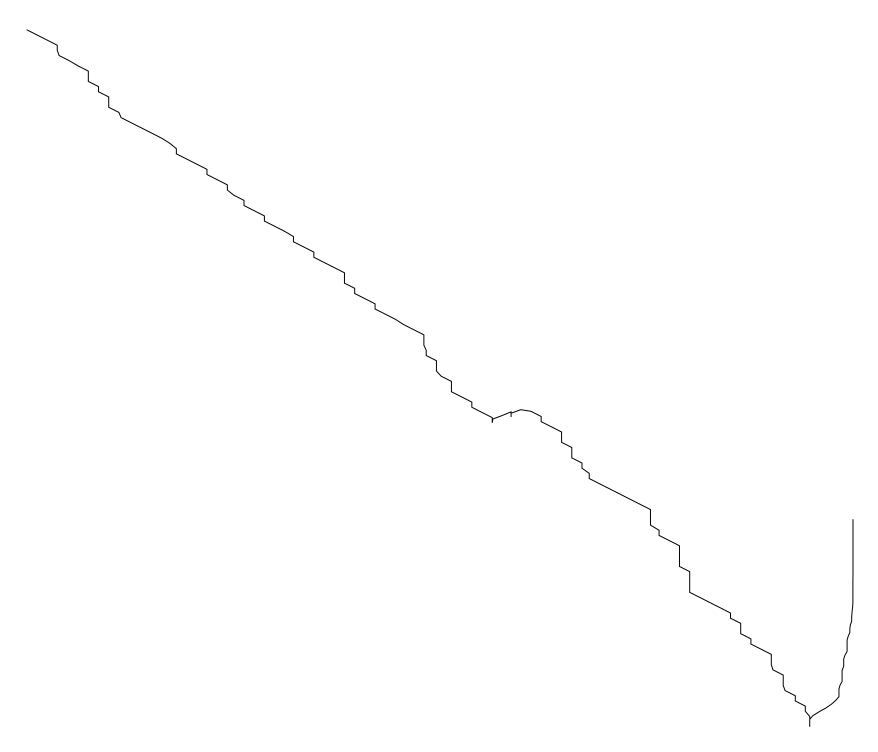

Episode: 1, reward = 0.6951191983122362
Episode: 2, reward = 0.8766990154711674
Episode: 3, reward = 0.8393558368495078
Episode: 4, reward = 0.8999722222222222
Episode: 5, reward = 0.8826849507735584
Episode: 6, reward = 0.882493670886076
Episode: 7, reward = 0.7743688466947961
Episode: 8, reward = 0.6953635724331926
Episode: 9, reward = 0.7563340365682137
Episode: 10, reward = 0.8600098452883264


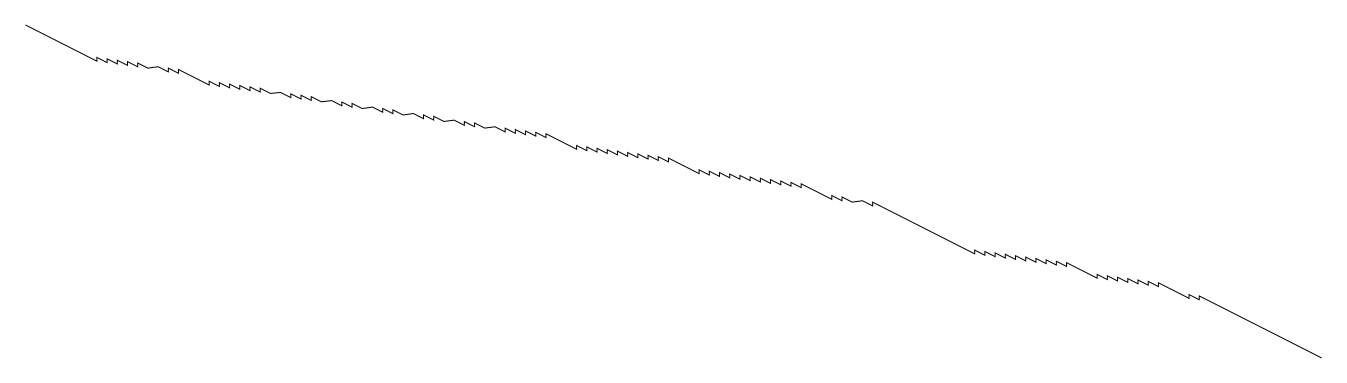

Episode: 11, reward = 0.909618846694796
Episode: 12, reward = 0.909618846694796
Episode: 13, reward = 0.909618846694796
Episode: 14, reward = 0.909618846694796
Episode: 15, reward = 0.909618846694796
Episode: 16, reward = 0.9087661744022504
Episode: 17, reward = 0.8968653305203937
Episode: 18, reward = 0.8965066807313643
Episode: 19, reward = 0.895426511954993


INFO:tensorflow:Assets written to: actor_model/assets


INFO:tensorflow:Assets written to: actor_model/assets


INFO:tensorflow:Assets written to: critic_model/assets


INFO:tensorflow:Assets written to: critic_model/assets


INFO:tensorflow:Assets written to: target_actor_model/assets


INFO:tensorflow:Assets written to: target_actor_model/assets


INFO:tensorflow:Assets written to: target_critic_model/assets


INFO:tensorflow:Assets written to: target_critic_model/assets


Saved all models to directory: /content/drive/My Drive/vinci-old/model/Pixel Maximizer


In [23]:
#Train the models
history = train()

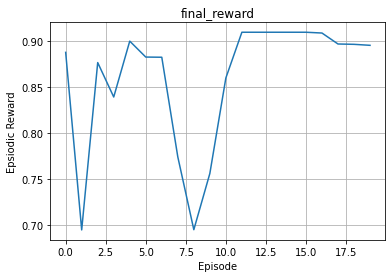

Plot saved to ./results/Pixel Maximizer/final_reward.png


In [24]:
#Plot reward
plot_reward(history)

In [29]:
#Evaluate target actor
strokes = get_ground_truth()

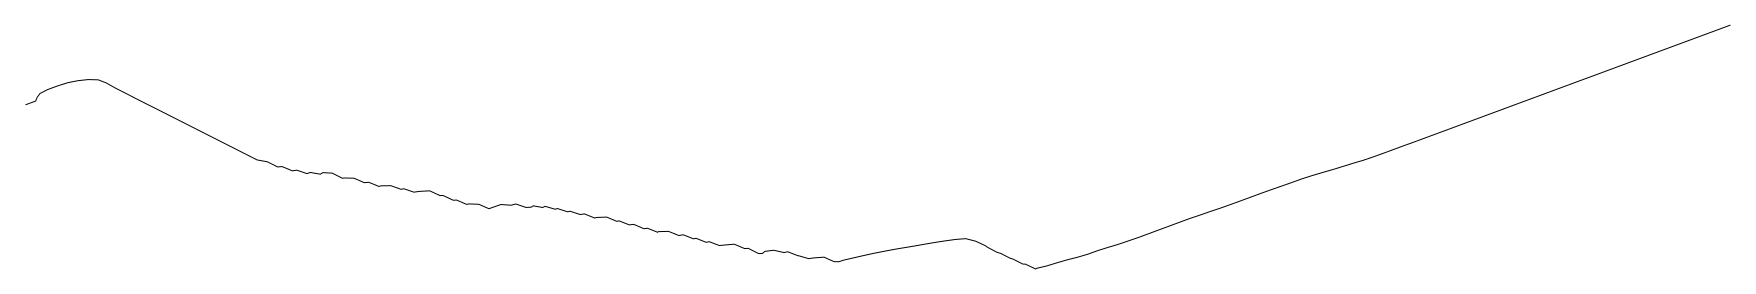

In [30]:
#Draw the evaluation results
draw.draw_strokes(strokes, svg_filename='./results/' + Model_Name + '/final.svg', save_to_file=True, show=True)